In [ ]:
WORK IN PROGRES !

## Types definition

In [15]:
from typing import TypedDict

class TGisNode(TypedDict):
    id: int
    lat: float
    lon: float

class TGisFeature(TypedDict):
    id: int
    nodes: [TGisNode]
    tags: Dict[str, Any]


## OverPass API consumer / data provider

In [20]:
import requests
from typing import Any, Dict, List, Tuple, Union

# Define los tipos personalizados para tu aplicación
TGisFeature = Dict[str, Union[int, List[Dict[str, float]], Dict[str, Any]]]
WayDTO = Dict[str, Union[int, List[Dict[str, float]], Dict[str, Any]]]

class OverPassGeoRepository():

    def find_ways_in_radius(self, center_coords: Tuple[float, float], radius: float) -> List[TGisFeature]:
        overpass_url = "https://overpass-api.de/api/interpreter"
        overpass_query = f"""
        [out:json];
        (
            way["highway"](around:{radius},{center_coords[0]},{center_coords[1]});
            node(around:{radius},{center_coords[0]},{center_coords[1]});
        );
        (._;>;);
        out body;
        """.strip()

        try:
            response = requests.get(overpass_url, params={
                                    'data': overpass_query})
            response.raise_for_status()
            response_data = response.json()

            # Asegúrate de que encontraste 'elements' en la respuesta
            if 'elements' not in response_data:
                raise ValueError(
                    'overpass: la respuesta no tiene el campo elements (respuesta inesperada)')

            return self.__process_overpass_response__(response_data)

        except requests.HTTPError as e:
            print(
                f"overpass: error HTTP {e.response.status_code if e.response else 'unknown'} al realizar la consulta: {e.response.text if e.response else 'unknown'}")
        except ValueError as ve:
            print(f"overpass: error al decodificar la respuesta: {ve}")
        return []

    def __process_overpass_response__(self, response: Dict[str, Any]) -> List[TGisFeature]:
        ways = []
        nodes_cache = {}

        # Primero: procesa los nodos
        for element in response['elements']:
            if element['type'] == 'node':
                nodes_cache[element['id']] = {
                    "id": element['id'],
                    "lat": element['lat'],
                    "lon": element['lon']
                }

        # Luego: procesa los caminos
        for element in response['elements']:
            if element['type'] == 'way':
                nodes = [nodes_cache.get(node_id, {})
                         for node_id in element['nodes']]
                
                way: TGisFeature = {
                    "id": element['id'],
                    "nodes": nodes,
                    "tags": element.get('tags', {})
                }
                ways.append(way)

        return ways


## Fetch GIS features representing roads on a given buffer

In [136]:
repo = OverPassGeoRepository()

lat = -39.81060061418378
lon = -73.25732485574258
center_coords = [lat, lon]
radius = 500

gis_features = repo.find_ways_in_radius(center_coords, radius)


## Use networkx to generate a Graph from the obtained features (interpreted as roads/ways/paths)

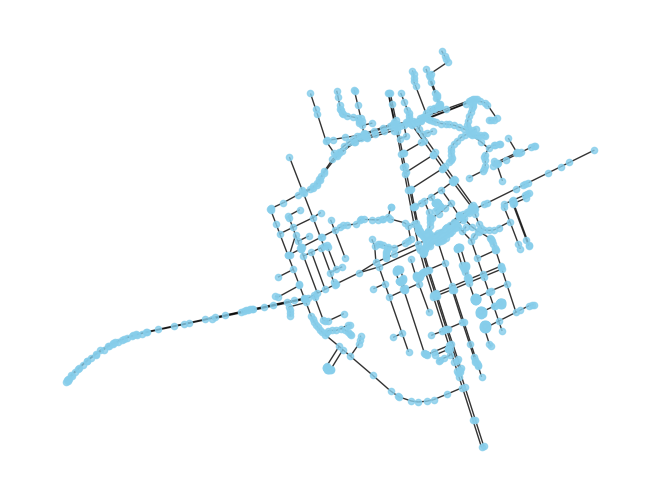

In [137]:
import networkx as nx
import matplotlib.pyplot as plt

# Crear un grafo vacío de NetworkX
G = nx.Graph()

# Recorrer cada característica GIS
for feature in gis_features:
    feature_id = feature['id']
    
    # Inicializar el nodo anterior como None
    prev_node = None
    
    # Agregar nodos al grafo y almacenar sus propiedades
    for node in feature['nodes']:
        node_id = node['id']
        coordinates = (node['lat'], node['lon'])
        
        G.add_node(node_id, coordinates=coordinates)
        
        # Crear bordes adyacentes entre nodos
        if prev_node is not None:
            G.add_edge(prev_node, node_id)
        
        prev_node = node_id

# Dibujar el grafo
pos = {node_id: coordinates for node_id, coordinates in nx.get_node_attributes(G, 'coordinates').items()}
nx.draw(G, pos, with_labels=False, node_size=20, node_color="skyblue", alpha=0.8)
plt.axis('off')
plt.show()




## Find shortest path between two random nodes on the graph

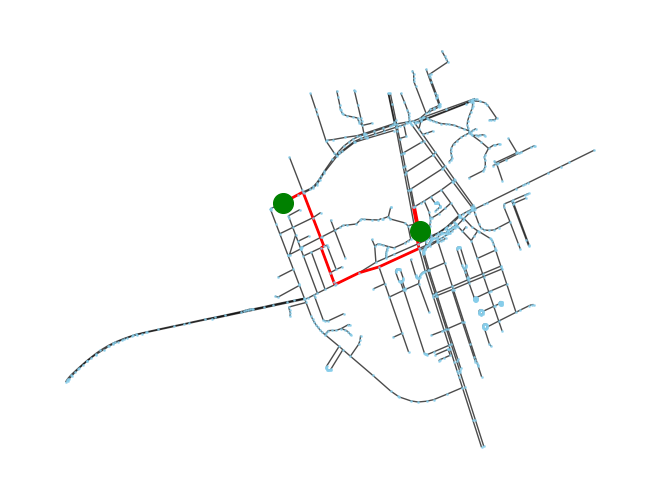

Camino más corto: [7547134605, 7547134604, 7547134603, 7547134602, 1183176867, 3396413043, 3396413044, 1183176688, 1183176806, 1181392029, 1181393130, 4612386081, 4612386078, 1181391305, 1181392436, 1181391445, 1181391828, 1183176577, 1183176637, 1183176889, 1181392601, 1183176870]


In [68]:
import networkx as nx
import matplotlib.pyplot as plt
import random
from geopy.distance import geodesic

# Crear una función para calcular la distancia entre dos nodos
def calculate_distance(G, node_A, node_B):
    coord_A = G.nodes[node_A]['coordinates']
    coord_B = G.nodes[node_B]['coordinates']
    return geodesic(coord_A, coord_B).meters

# Obtener dos nodos aleatorios del grafo con una distancia mínima de 100 metros
while True:
    node_A = random.choice(list(G.nodes))
    node_B = random.choice(list(G.nodes))
    if node_A != node_B and calculate_distance(G, node_A, node_B) >= 100:
        break

# Encontrar el camino más corto entre los nodos A y B
shortest_path = nx.shortest_path(G, source=node_A, target=node_B)

# Dibujar el grafo
pos = {node_id: coordinates for node_id, coordinates in nx.get_node_attributes(G, 'coordinates').items()}
nx.draw(G, pos, with_labels=False, node_size=1, node_color="skyblue", alpha=0.7)

# Dibujar el camino más corto en color rojo
path_edges = [(shortest_path[i], shortest_path[i + 1]) for i in range(len(shortest_path) - 1)]
nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color="red", width=2)

# Marcar los nodos A y B
nx.draw_networkx_nodes(G, pos, nodelist=[node_A, node_B], node_color="green", node_size=200)

# Mostrar el grafo
plt.axis('off')
plt.show()

# Imprimir el camino más corto
print("Camino más corto:", shortest_path)



## A custom implementation of Dijktra 

In [148]:
def dijkstra(graph, start_node, target_node):
    visited = set()
    distances = {node: float('inf') for node in graph.nodes}
    previous_nodes = {}

    # Initial distance (start node)
    distances[start_node] = 0

    while len(visited) < len(graph.nodes):
        # Non-visited node with shortest distance
        current_node = min((node for node in graph.nodes if node not in visited), key=lambda node: distances[node])

        # Marc node as visited
        visited.add(current_node)

        if current_node == target_node:
            break

        for neighbor in graph.neighbors(current_node):
            # New distance
            tentative_distance = distances[current_node] + graph[current_node][neighbor].get('weight', 1)

            if tentative_distance < distances[neighbor]:
                # Update distance (if shorter)
                distances[neighbor] = tentative_distance
                previous_nodes[neighbor] = current_node

    # Construct a path to represent the "shortest path"
    shortest_path = []
    current = target_node
    while current is not None:
        shortest_path.insert(0, current)
        current = previous_nodes.get(current)

    return shortest_path

In [149]:
# Helper funcion: calculate_distance
def calculate_distance(G, node_A, node_B):
    coord_A = G.nodes[node_A]['coordinates']
    coord_B = G.nodes[node_B]['coordinates']
    return geodesic(coord_A, coord_B).meters

## Try to find the shortests path with the custom implementation

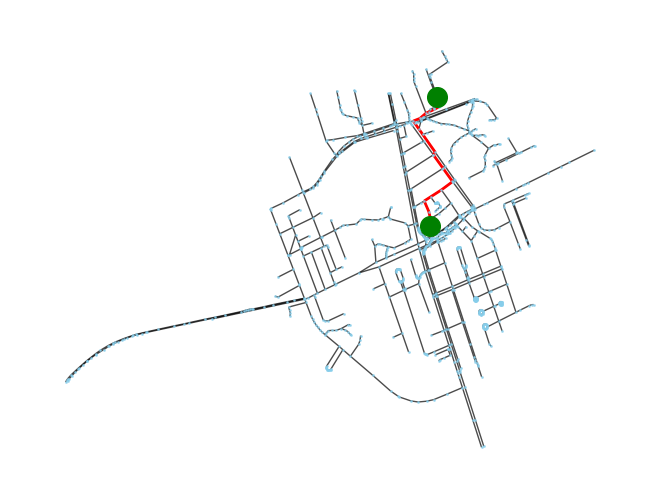

Camino más corto: [6121162050, 6101463161, 1181391814, 1181392509, 6121162052, 1395249364, 1181391590, 1181391679, 1183176850, 3960000131, 7029435946, 5805103160, 1181392682, 1181392191, 1181391420, 5585401626, 1181391756, 1181392957, 9348569177, 1183176789, 7547134597, 7547134599, 7547134617, 7547134616, 7547134615]


In [150]:


# Obtener dos nodos aleatorios del grafo con una distancia mínima de 100 metros
while True:
    node_A = random.choice(list(G.nodes))
    node_B = random.choice(list(G.nodes))
    if node_A != node_B and calculate_distance(G, node_A, node_B) >= 100:
        break

# Encontrar el camino más corto entre los nodos A y B
shortest_path = dijkstra(G, node_A, node_B)

pos = {node_id: coordinates for node_id, coordinates in nx.get_node_attributes(G, 'coordinates').items()}
nx.draw(G, pos, with_labels=False, node_size=1, node_color="skyblue", alpha=0.7)

# Dibujar el camino más corto en color rojo
path_edges = [(shortest_path[i], shortest_path[i + 1]) for i in range(len(shortest_path) - 1)]
nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color="red", width=2)

# Marcar los nodos A y B
nx.draw_networkx_nodes(G, pos, nodelist=[node_A, node_B], node_color="green", node_size=200)

# Mostrar el grafo
plt.axis('off')
plt.show()

# Imprimir el camino más corto
print("Camino más corto:", shortest_path)


## Find cycles using networkx 

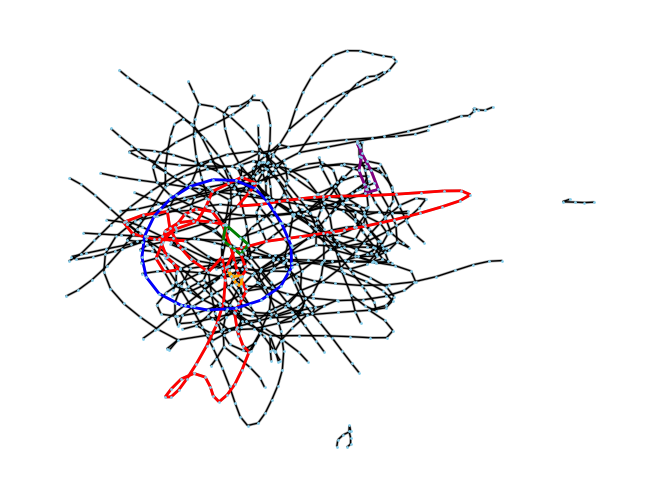

In [151]:
import colorsys


# Encuentra los ciclos en el grafo
cycles = nx.cycle_basis(G)

N = 5  # Ciclos aleatorios para imprimir
random_cycles = random.sample(cycles, N)

# Colores predefinidos
colors = ['red', 'blue', 'green', 'orange', 'purple']

# Dibuja el grafo base con los caminos en color negro
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=False, node_size=1, node_color="skyblue")
nx.draw_networkx_edges(G, pos, width=2.0, edge_color='black', alpha=0.3)

# Dibuja las aristas de los ciclos con colores predefinidos
for i, random_cycle in enumerate(random_cycles):
    color = colors[i % len(colors)]  # Ciclos se asignan a colores en bucle
    for j in range(len(random_cycle)):
        edge = (random_cycle[j], random_cycle[(j + 1) % len(random_cycle)])  # Obtiene aristas del ciclo
        nx.draw_networkx_edges(G, pos, edgelist=[edge], edge_color=color, width=2.0, alpha=1)

# Mostrar el grafo en el Jupyter Notebook
plt.show()


## A custom implementation attemp for finding cycles

In [152]:
def find_cycles(graph):
    def dfs(node, parent):
        visited.add(node)
        cycle_stack.append(node)

        for neighbor in graph.neighbors(node):
            if neighbor == parent:
                continue  # Ignorar el nodo padre en la búsqueda
            if neighbor in cycle_stack:
                # Se ha encontrado un ciclo, agregarlo a la lista de ciclos
                cycle = cycle_stack[cycle_stack.index(neighbor):]
                cycles.append(cycle)
            elif neighbor not in visited:
                # Continuar la búsqueda en el vecino no visitado
                dfs(neighbor, node)

        cycle_stack.pop()

    visited = set()
    cycles = []
    cycle_stack = []

    for node in graph.nodes():
        if node not in visited:
            dfs(node, None)

    return cycles

## Try the custom cycle finding function

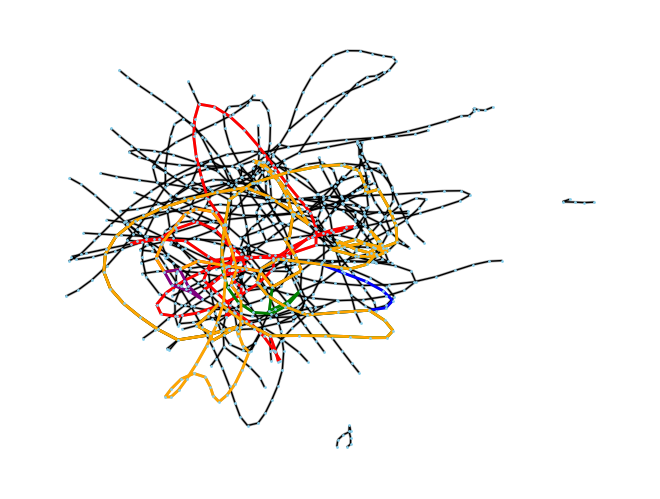

In [154]:
cycles = find_cycles(G)

N = 5  # Ciclos aleatorios para imprimir
random_cycles = random.sample(cycles, N)

# Dibuja el grafo base con los caminos en color negro
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=False, node_size=1, node_color="skyblue")
nx.draw_networkx_edges(G, pos, width=2.0, edge_color='black', alpha=0.3)

# Dibuja las aristas de los ciclos con colores predefinidos
for i, random_cycle in enumerate(random_cycles):
    color = colors[i % len(colors)]  # Ciclos se asignan a colores en bucle
    for j in range(len(random_cycle)):
        edge = (random_cycle[j], random_cycle[(j + 1) % len(random_cycle)])  # Obtiene aristas del ciclo
        nx.draw_networkx_edges(G, pos, edgelist=[edge], edge_color=color, width=2.0, alpha=1)

# Mostrar el grafo en el Jupyter Notebook
plt.show()


## Custom Graph class (we'll try to decouple from networkx, just for kicks...)

In [10]:
class Graph:
    def __init__(self):
        self.nodes = {}  # Diccionario para almacenar nodos
        self.edges = []  # Lista para almacenar aristas

    def add_node(self, node_id):
        if node_id not in self.nodes:
            self.nodes[node_id] = []

    def add_edge(self, node1, node2):
        if node1 not in self.nodes:
            self.add_node(node1)
        if node2 not in self.nodes:
            self.add_node(node2)

        self.edges.append((node1, node2))
        # Agregar conexiones a los nodos
        self.nodes[node1].append(node2)
        self.nodes[node2].append(node1)

    def find_neighbors(self, node_id):
        if node_id in self.nodes:
            return self.nodes[node_id]
        else:
            return []

    def get_nodes(self):
        return list(self.nodes.keys())

    def get_edges(self):
        return self.edges